<a href="https://colab.research.google.com/github/Sujeetpanda/ML/blob/master/HAR_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Importing Libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive 
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [0]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
 ax.plot(x, vy, 'b', label="Validation Loss")
 ax.plot(x, ty, 'r', label="Train Loss")
 plt.legend()
 plt.grid()
 fig.canvas.draw()

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/drive/My Drive/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/drive/My Drive/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [0]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [0]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [0]:
!ls "/content/drive/My Drive"

'Colab Notebooks'   Resume_Ajit.doc   test.csv	 train.csv


In [0]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [0]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim),return_sequences=True))
# Adding a dropout layer
model.add(Dropout(0.5))
#Adding LSTM layer2
model.add(LSTM(20))
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 20)                4240      
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 126       
Total params: 9,742
Trainable params: 9,742
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 54s 7ms/step - loss: 0.1759 - acc: 0.9433 - val_loss: 0.4292 - val_acc: 0.8975
Epoch 2/30
7352/7352 [==============================] - 54s 7ms/step - loss: 0.1782 - acc: 0.9437 - val_loss: 0.5832 - val_acc: 0.9074
Epoch 3/30
7352/7352 [==============================] - 54s 7ms/step - loss: 0.1774 - acc: 0.9440 - val_loss: 0.4903 - val_acc: 0.8962
Epoch 4/30
7352/7352 [==============================] - 54s 7ms/step - loss: 0.1673 - acc: 0.9448 - val_loss: 0.4870 - val_acc: 0.9053
Epoch 5/30
7352/7352 [==============================] - 55s 7ms/step - loss: 0.1567 - acc: 0.9524 - val_loss: 0.4249 - val_acc: 0.9077
Epoch 6/30
7352/7352 [==============================] - 54s 7ms/step - loss: 0.1534 - acc: 0.9494 - val_loss: 0.5312 - val_acc: 0.9063
Epoch 7/30
7352/7352 [==============================] - 55s 7ms/step - loss: 0.1774 - acc: 0.9480 - val_loss: 0.5193 - val_acc: 0.9050
Epoch 8

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 510        0  ...                   0                 0
SITTING                  1      393  ...                   0                 0
STANDING                 0      106  ...                   0                 0
WALKING                  0        1  ...                  28                 4
WALKING_DOWNSTAIRS       0        0  ...                 407                13
WALKING_UPSTAIRS         0        1  ...                   9               453

[6 rows x 6 columns]


In [0]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 2s 598us/step


In [0]:
score

[0.6094993375524109, 0.8992195453003053]

- With a simple 2 layer architecture we got 92.12% accuracy and a loss of 0.37
- We can further imporve the performace with Hyperparameter tuning

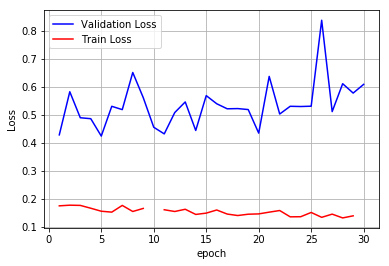

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Loss')
x = list(range(1,epochs+1))

vy1 = history.history['val_loss']
ty1 = history.history['loss']
plt_dynamic(x, vy1, ty1, ax)

In [0]:
################

In [0]:
from keras.layers.normalization import BatchNormalization
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim),return_sequences=True))
# Adding a dropout layer
model.add(Dropout(0.4))
#Adding LSTM layer2
model.add(LSTM(20))
model.add(Dropout(0.4))
model.add(BatchNormalization())
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

W0625 23:47:54.783077 139662037555072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0625 23:47:54.790283 139662037555072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 23:47:54.798794 139662037555072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0625 23:47:55.003332 139662037555072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0625 23:47:55.012039 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                4240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 9,822
Trainable params: 9,782
Non-trainable params: 40
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

W0625 23:48:00.554600 139662037555072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0625 23:48:00.587253 139662037555072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [0]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

W0625 23:48:05.401105 139662037555072 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 192s 26ms/step - loss: 1.1726 - acc: 0.5316 - val_loss: 0.8162 - val_acc: 0.7044
Epoch 2/30
7352/7352 [==============================] - 185s 25ms/step - loss: 0.7946 - acc: 0.6383 - val_loss: 0.7177 - val_acc: 0.6865
Epoch 3/30
7352/7352 [==============================] - 184s 25ms/step - loss: 0.6149 - acc: 0.7522 - val_loss: 0.6250 - val_acc: 0.7893
Epoch 4/30
7352/7352 [==============================] - 183s 25ms/step - loss: 0.4003 - acc: 0.8766 - val_loss: 0.5269 - val_acc: 0.8459
Epoch 5/30
7352/7352 [==============================] - 181s 25ms/step - loss: 0.3207 - acc: 0.9018 - val_loss: 0.4816 - val_acc: 0.8619
Epoch 6/30
7352/7352 [==============================] - 182s 25ms/step - loss: 0.2648 - acc: 0.9140 - val_loss: 0.4951 - val_acc: 0.8775
Epoch 7/30
7352/7352 [==============================] - 181s 25ms/step - loss: 0.2280 - acc: 0.9219 - val_loss: 0.3524 - val_acc: 

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 511        0  ...                   0                26
SITTING                  3      387  ...                   0                21
STANDING                 0      105  ...                   0                 0
WALKING                  0        0  ...                   8                 2
WALKING_DOWNSTAIRS       1        0  ...                 414                 0
WALKING_UPSTAIRS         3        2  ...                   1               435

[6 rows x 6 columns]


In [0]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 13s 4ms/step


In [0]:
score

[0.5424100616930853, 0.9022734984730234]

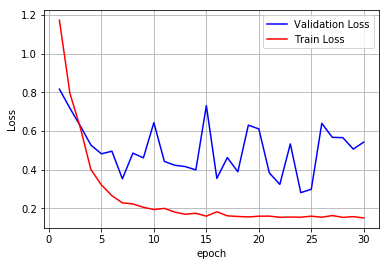

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Loss')
x = list(range(1,epochs+1))

vy1 = history.history['val_loss']
ty1 = history.history['loss']
plt_dynamic(x, vy1, ty1, ax)

In [0]:
from keras.layers.normalization import BatchNormalization
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(16, input_shape=(timesteps, input_dim),return_sequences=True))
# Adding a dropout layer
model.add(Dropout(0.5))
#Adding LSTM layer2
model.add(LSTM(20))
model.add(Dropout(0.5))
model.add(BatchNormalization())
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 16)           1664      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 16)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 20)                2960      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 20)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 126       
Total params: 4,830
Trainable params: 4,790
Non-trainable params: 40
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 184s 25ms/step - loss: 1.3248 - acc: 0.4652 - val_loss: 1.0418 - val_acc: 0.5914
Epoch 2/30
7352/7352 [==============================] - 181s 25ms/step - loss: 0.9037 - acc: 0.6242 - val_loss: 0.7734 - val_acc: 0.6183
Epoch 3/30
7352/7352 [==============================] - 180s 24ms/step - loss: 0.7630 - acc: 0.6616 - val_loss: 0.7612 - val_acc: 0.6692
Epoch 4/30
7352/7352 [==============================] - 179s 24ms/step - loss: 0.6967 - acc: 0.6902 - val_loss: 0.6616 - val_acc: 0.7329
Epoch 5/30
7352/7352 [==============================] - 181s 25ms/step - loss: 0.6302 - acc: 0.7413 - val_loss: 0.6124 - val_acc: 0.7869
Epoch 6/30
7352/7352 [==============================] - 180s 24ms/step - loss: 0.5315 - acc: 0.8043 - val_loss: 0.6409 - val_acc: 0.8161
Epoch 7/30
7352/7352 [==============================] - 181s 25ms/step - loss: 0.4752 - acc: 0.8326 - val_loss: 0.6404 - val_acc: 

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 520        2  ...                   0                 0
SITTING                  0      331  ...                   1                 4
STANDING                 0       44  ...                   0                 2
WALKING                  0        0  ...                   2                22
WALKING_DOWNSTAIRS       0        0  ...                 407                 5
WALKING_UPSTAIRS         0        0  ...                   3               465

[6 rows x 6 columns]


In [0]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 13s 5ms/step


In [0]:
score

[0.3193548226802096, 0.9066847641669494]

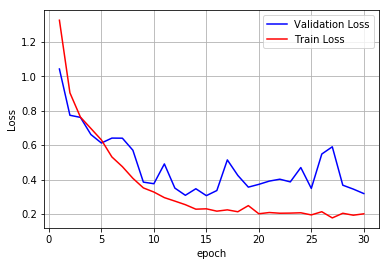

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Loss')
x = list(range(1,epochs+1))

vy1 = history.history['val_loss']
ty1 = history.history['loss']
plt_dynamic(x, vy1, ty1, ax)

In [0]:
from keras.layers.normalization import BatchNormalization
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(32, input_shape=(timesteps, input_dim),return_sequences=True))
model.add(BatchNormalization())
# Adding a dropout layer
model.add(Dropout(0.5))
#Adding LSTM layer2
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(BatchNormalization())
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

W0626 06:29:57.744171 140114888222592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0626 06:29:57.768676 140114888222592 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32)           128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total para

In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

W0626 06:30:03.778546 140114888222592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0626 06:30:03.809847 140114888222592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [0]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

W0626 06:30:08.402955 140114888222592 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 200s 27ms/step - loss: 1.0858 - acc: 0.5987 - val_loss: 0.7729 - val_acc: 0.6525
Epoch 2/30
7352/7352 [==============================] - 194s 26ms/step - loss: 0.7320 - acc: 0.6994 - val_loss: 0.9675 - val_acc: 0.6335
Epoch 3/30
7352/7352 [==============================] - 192s 26ms/step - loss: 0.5471 - acc: 0.7854 - val_loss: 0.5732 - val_acc: 0.7937
Epoch 4/30
7352/7352 [==============================] - 193s 26ms/step - loss: 0.4070 - acc: 0.8538 - val_loss: 1.1617 - val_acc: 0.7581
Epoch 5/30
7352/7352 [==============================] - 191s 26ms/step - loss: 0.3052 - acc: 0.8983 - val_loss: 0.9434 - val_acc: 0.7547
Epoch 6/30
7352/7352 [==============================] - 192s 26ms/step - loss: 0.2678 - acc: 0.9117 - val_loss: 0.3766 - val_acc: 0.8816
Epoch 7/30
7352/7352 [==============================] - 192s 26ms/step - loss: 0.2327 - acc: 0.9233 - val_loss: 0.2334 - val_acc: 

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 537        0  ...                   0                 0
SITTING                  0      381  ...                   0                 0
STANDING                 0       81  ...                   0                 0
WALKING                  0        0  ...                  26                 0
WALKING_DOWNSTAIRS       0        0  ...                 420                 0
WALKING_UPSTAIRS         0       10  ...                  14               432

[6 rows x 6 columns]


In [0]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 14s 5ms/step


In [0]:
score

[0.3769732857711676, 0.9127926705123854]

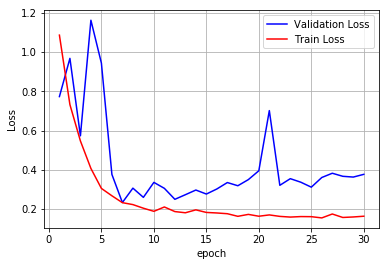

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Loss')
x = list(range(1,epochs+1))

vy1 = history.history['val_loss']
ty1 = history.history['loss']
plt_dynamic(x, vy1, ty1, ax)

In [27]:
from keras.layers.normalization import BatchNormalization
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(64, input_shape=(timesteps, input_dim),return_sequences=True))
model.add(BatchNormalization())
# Adding a dropout layer
model.add(Dropout(0.3))
#Adding LSTM layer2
model.add(LSTM(64))
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 64)           256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 52,614
Trainable params: 52,486
Non-trainable params: 128
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [29]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 194s 26ms/step - loss: 0.7659 - acc: 0.7291 - val_loss: 0.4963 - val_acc: 0.8320
Epoch 2/30
7352/7352 [==============================] - 190s 26ms/step - loss: 0.2854 - acc: 0.9100 - val_loss: 0.2504 - val_acc: 0.9169
Epoch 3/30
7352/7352 [==============================] - 190s 26ms/step - loss: 0.2106 - acc: 0.9257 - val_loss: 0.5413 - val_acc: 0.8069
Epoch 4/30
7352/7352 [==============================] - 184s 25ms/step - loss: 0.1862 - acc: 0.9334 - val_loss: 0.5743 - val_acc: 0.8310
Epoch 5/30
7352/7352 [==============================] - 177s 24ms/step - loss: 0.1668 - acc: 0.9365 - val_loss: 0.2945 - val_acc: 0.9145
Epoch 6/30
7352/7352 [==============================] - 177s 24ms/step - loss: 0.1674 - acc: 0.9391 - val_loss: 0.3025 - val_acc: 0.9057
Epoch 7/30
7352/7352 [==============================] - 175s 24ms/step - loss: 0.1470 - acc: 0.9430 - val_loss: 0.3044 - val_acc: 

In [30]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 537        0  ...                   0                 0
SITTING                  2      385  ...                   0                 0
STANDING                 0       54  ...                   0                 0
WALKING                  0        0  ...                  25                 2
WALKING_DOWNSTAIRS       0        0  ...                 415                 4
WALKING_UPSTAIRS         0        0  ...                  16               454

[6 rows x 6 columns]


In [31]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 13s 4ms/step


In [32]:
score

[0.35462715743362244, 0.9284017645062775]

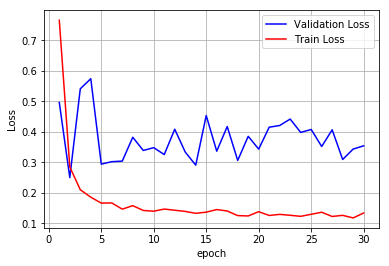

In [33]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Loss')
x = list(range(1,epochs+1))

vy1 = history.history['val_loss']
ty1 = history.history['loss']
plt_dynamic(x, vy1, ty1, ax)

In [34]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Layers","accuracy"]
x.add_row(["LSTM(128)-drop(0.5)-LSTM(20)-DROPOUT(0.5)-Dense",.89])
x.add_row(["LSTM(128)-drop(0.4)-LSTM(20)-DROPOUT(0.4)-Dense",.90])
x.add_row(["LSTM(16)-drop(0.5)-LSTM(20)-DROPOUT(0.5)-BN-Dense",.90])
x.add_row(["LSTM(32)-BN-drop(0.5)-LSTM(32)-DROPOUT(0.5)-BN-Dense",.91])
x.add_row(["LSTM(64)-BN-drop(0.3)-LSTM(64)-DROPOUT(0.5)-Dense",.92])


print(x)

+------------------------------------------------------+----------+
|                        Layers                        | accuracy |
+------------------------------------------------------+----------+
|   LSTM(128)-drop(0.5)-LSTM(20)-DROPOUT(0.5)-Dense    |   0.89   |
|   LSTM(128)-drop(0.4)-LSTM(20)-DROPOUT(0.4)-Dense    |   0.9    |
|  LSTM(16)-drop(0.5)-LSTM(20)-DROPOUT(0.5)-BN-Dense   |   0.9    |
| LSTM(32)-BN-drop(0.5)-LSTM(32)-DROPOUT(0.5)-BN-Dense |   0.91   |
|  LSTM(64)-BN-drop(0.3)-LSTM(64)-DROPOUT(0.5)-Dense   |   0.92   |
+------------------------------------------------------+----------+
